In [1]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from math import *
import numpy as np
import os
from IPython.display import HTML
from tqdm import tqdm
from PIL import Image

In [2]:
from tensorflow.examples.tutorials.mnist import input_data

mnist = input_data.read_data_sets("../dataset/")

/root/.pyenv/versions/3.6.2/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


Extracting ../dataset/train-images-idx3-ubyte.gz
Extracting ../dataset/train-labels-idx1-ubyte.gz
Extracting ../dataset/t10k-images-idx3-ubyte.gz
Extracting ../dataset/t10k-labels-idx1-ubyte.gz


In [3]:
interval = 0.01

In [4]:
# 3x3 memristor crossbar
# 전압으로 MEMRISTOR 저
class Memristor:
    def __init__(self, name):
        self.name = name
        self.x = 0.1
        self.xp = 0.1
        self.xn = 0.2
        self.vp = 1.5
        self.vn = 0.7
        self.alphap = 6
        self.alphan = 4
        self.a1 = 4e-4
        self.a2 = 3e-4
        self.ap = 0.032
        self.an = 0.001
        self.b = 1.0
        
        self.gf = 0.0
        
        self.interval = interval
        self.conductance = 0
        self.resistance = 0
    
    def change_x(self, V):
        if V >= 0:
            if self.x >= self.xp:
                self.f = exp(-self.alphap*(self.x - self.xp)) * (((self.xp - self.x)/(1 - self.xp)) + 1)
            else:
                self.f = 1.0
        elif V < 0:
            if self.x <= (1 - self.xn):
                self.f = exp(self.alphan*(self.x + self.xn - 1.0)) * (self.x/(1-self.xn))
            else:
                self.f = 1.0
            
        if V > self.vp:
            self.g = self.ap * (exp(V)-exp(self.vp))
        elif V < -self.vn:
            self.g = -self.an * (exp(-V)-exp(self.vn))
        else:
            self.g = 0
            
        self.gf = self.f * self.g
        self.x += self.gf * self.interval
    
    def activate(self, V):
        self.change_x(V)
        
        if V >= 0:
            curr = self.a1 * self.x * sinh(self.b * V)
        else:
            curr = self.a2 * self.x * sinh(self.b * V)
        
        try: self.resistance = V / curr
        except ZeroDivisionError as e:
            print(e)
            
        try: self.conductance = 1 / self.resistance
        except ZeroDivisionError as e:
            print(e)
            
        return curr

In [5]:
class DataBalancing:
    def __init__(self):
        self.quantity = 60000
        self.balance_num = 2000
    
    def activate(self):
        self.images = mnist.train.images[:self.quantity]
        self.labels = mnist.train.labels[:self.quantity]
        self.data_dict = {}
        for i in range(10):
            self.data_dict[i] = []
        for ii,num in enumerate(self.labels):
            self.data_dict[num].append(self.images[ii])
        
        for i in range(10):
            self.data_dict[i][:self.balance_num]
            
        self.output_list = []
        self.label_list = []
        for times in tqdm(range(self.balance_num)):
            for ii in range(10):
                self.output_list.append(self.data_dict[ii][times])
                self.label_list.append(ii)
                
        return self.output_list, self.label_list

In [6]:
databalance = DataBalancing()
balanced_image_list, balanced_label_list = databalance.activate()
del databalance

100%|██████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:00<00:00, 268469.82it/s]


# reverse imaging

In [11]:
class AfterReverseImaging:
    def __init__(self, images, labels, quantity=4000):
        self.quantity = quantity
        self.images = images
        self.labels = labels
        self.size = 22
        self.row_num = self.size**2
        self.column_num = 10
        self.loss_list=[]
        self.accuracy_list=[]
        
    def make_mem_crossbar(self, cross_id):
        # Build Memristor crossbar
        for i in range(self.row_num):
            for j in range(self.column_num):
                exec('self.mem_%c_%d_%d = Memristor("mem_%c_%d_%d")'%(cross_id,i,j,cross_id,i,j))
        
    def crossbar_matrix(self):
        self.mem_matrix = {'o':[],'r':[]}
        for row in range(self.row_num):
            row_list = []
            for column in range(self.column_num):
                exec('row_list.append(self.mem_%c_%d_%d.conductance)'%('o',row,column))
            self.mem_matrix['o'].append(row_list)
            
        for row in range(self.row_num):
            row_list = []
            for column in range(self.column_num):
                exec('row_list.append(self.mem_%c_%d_%d.conductance)'%('r',row,column))
            self.mem_matrix['r'].append(row_list)
    
    def data_size_reduction(self):
        #os.mkdir("../dataset/size_reduced_image_path")
        #os.chdir("../dataset/size_reduced_image_path")
        
        input_images = self.images[:self.quantity]
        labels = self.labels[:self.quantity]
        size_reducted_images = []
        for im in input_images:
            pil_im = Image.fromarray(np.reshape(im, [28,28]))
            size_reducted_images.append(np.reshape(np.array(pil_im.resize([self.size, self.size])), [1, self.row_num])[0])
        return size_reducted_images, labels
    
    def reverse(self, image):
        return 1.0 - np.array(image)
    
    def split_train_test(self, images, labels, train_ratio=0.90):
        # img path 를 받아서 train, test set을 list로 추출해서 나눠줌 --> path는 좀 더 데이터 사이즈가 커졌을 때 사용해도 될 듯
        train_quantity = int(len(images)*train_ratio)
        train_image_list = images[:train_quantity]
        train_label_list = labels[:train_quantity]
        test_image_list = images[train_quantity:]
        test_label_list = labels[train_quantity:]
        return train_image_list, train_label_list, test_image_list, test_label_list
    
    def after_imaging(self, train_image, train_label, insert_time=0.6):
        # ms 단위의 이미지 sending (그 때 써놓았던 방식대로 작동될 수 있도록 하기)
        # image의 검은 부분은 -V 로 들어갈 수 있도록 만들기
        # generator 을 사용해서 하나씩 넣는 method 를 만들어도 괜찮을것같다. 
        voltage_inputs = np.array(train_image)+1.0
        for i, V in enumerate(voltage_inputs):
            for time in np.arange(0,insert_time,interval):
                exec('self.mem_%c_%d_%d.activate(V)'%('o',i,train_label))

        rev_voltage_inputs = self.reverse(train_image)+1.0
        for ii, VV in enumerate(rev_voltage_inputs):
            for non_label in [i for i in range(10) if i != train_label]:
                for time in np.arange(0,insert_time,interval):
                    exec('self.mem_%c_%d_%d.activate(VV)'%('r',ii,non_label))
        
    def mem_output(self, cross_id, image_array):
        # 현재 멤리스터 상태에서 input 넣고 테스트하기
        crossbar_output = np.dot(image_array, self.mem_matrix[cross_id])
        return crossbar_output
    
    def total_output(self, image_array):
        minus_rate = 0.8
        return self.mem_output('o',image_array) - minus_rate*self.mem_output('r', self.reverse(image_array))
    
    def winner_take_all(self, crossbar_output):
        a = np.argmax(crossbar_output)
        output = np.zeros([10])
        output[a] = 1
        return output
    
    def loss_function(self):
        total_loss = 0.0
        for k, label in enumerate(self.train_label_list):
            label_onehot = np.zeros([1,10])
            label_onehot[0][label] = 1.0
            label_onehot = np.array(label_onehot[0])
            output = self.total_output(self.train_image_list[k])
            #Softmax used to check the loss function
            output = np.exp(output*10000)
            output /= np.sum(output)
            loss_array = label_onehot - output #--> softmax는 값이 너무 작아서 구현이 안되는 듯
            #loss_array = label_onehot - output/np.sum(output) # --> just normalized by dividing into sum
            loss = np.dot(loss_array, loss_array)
            total_loss += loss
        return total_loss*10/len(self.train_image_list)
    
    def train_data_gen(self):
        for image, label in list(zip(self.train_image_list, self.train_label_list)):
            yield image, label
    
    def crossbar_animation(self, train_data):
    # input 은 없으며 그저 crossbar resistance를 plotting 해줌.
    # 그 plotting을 에니메이션적으로 할 수 있으면 좋겠다. 
    # 그 기준축을 평균으로 잡고, scale도 분산을 계산해서 plotting 되는 것 같은데 그렇게 되지 않도록 하기
        self.after_imaging(train_data[0], train_data[1], insert_time=0.6)
        self.crossbar_matrix()
        #self.loss_list.append(self.loss_function())
        #self.accuracy_list.append(self.accuracy())
        self.ax1.clear()
        self.ax1.matshow(np.transpose(self.mem_matrix['o']), cmap=plt.cm.binary, vmin=0, vmax=5.0e-4)
        self.ax1.set_ylabel('Memristor column')
        self.ax1.set_xlabel('Memristor row')
        
#         self.ax2.clear()
#         self.ax2.set_xlim([0,100])
#         self.ax2.grid()
#         self.ax2.set_ylim([0,25])
#         self.ax2.set_ylabel('Loss')
#         self.ax2.set_xlabel('Number of Times')
#         self.ax2.plot(self.loss_list)
        
#         self.ax3.clear()
#         self.ax3.plot(self.accuracy_list)
#         self.ax3.set_xlim([0,100])
#         self.ax3.grid()
#         self.ax3.set_ylim([0,100])
#         self.ax3.set_ylabel('Accuracy(%)')
#         self.ax3.set_xlabel('Number of Times')
        
        self.ax4.clear()
        self.ax4.matshow(np.transpose(self.mem_matrix['r']), cmap=plt.cm.binary, vmin=0, vmax=5.0e-4)
        self.ax4.set_ylabel('Memristor column')
        self.ax4.set_xlabel('Memristor row')
    
    def accuracy(self):
        correct_number = 0
        for i, input_image in enumerate(self.test_image_list):
            if np.argmax(self.total_output(input_image)) == self.test_label_list[i]:
                correct_number += 1
        return round(correct_number*100/len(self.test_image_list), 2)
        
    def activate(self):
        fig = plt.figure(figsize=(16,9))
        self.ax1 = fig.add_subplot(2,1,1)
#         self.ax2 = fig.add_subplot(4,1,3)
#         self.ax3 = fig.add_subplot(4,1,4)
        self.ax4 = fig.add_subplot(2,1,2)
        
        print("Building two Memristor {}x{} crossbar...".format(self.row_num, self.column_num))
        self.make_mem_crossbar('o')
        self.make_mem_crossbar('r')
        self.crossbar_matrix()
        
        size_reducted_images, labels = self.data_size_reduction()
        self.train_image_list, self.train_label_list, self.test_image_list, self.test_label_list = self.split_train_test(size_reducted_images, labels)
        
        print('\nMaking animation...')
        self.anim = animation.FuncAnimation(fig, self.crossbar_animation, self.train_data_gen, interval=300, repeat=False)
        print('\nAll process done.')

Building two Memristor 484x10 crossbar...

Making animation...

All process done.


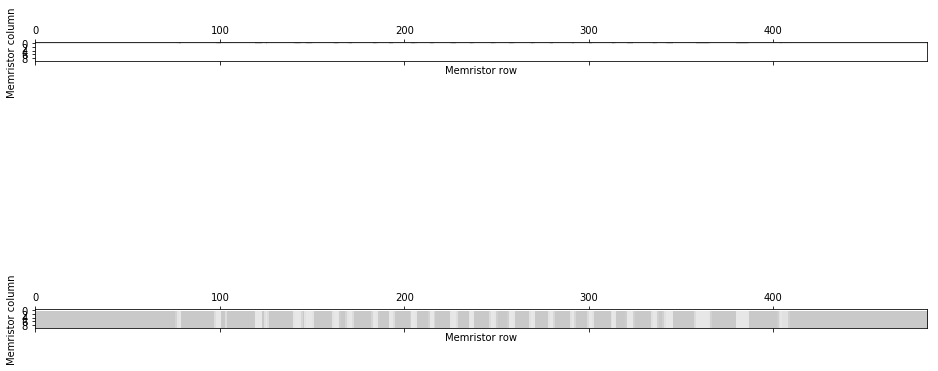

In [12]:
train_2 = AfterReverseImaging(balanced_image_list, balanced_label_list, quantity=20000)
train_2.activate()

In [13]:
train_2.accuracy()

10.0

In [14]:
Writer = animation.writers['ffmpeg']
writer = Writer(fps=5, metadata=dict(artist='Me'), bitrate=1800)

train_2.anim.save('../animation/mem_matrix_animation(reverseHD_9(transposed graph only) SADP).mp4', writer=writer)

# make figures for presentation

In [16]:
# plt.figure(figsize=(20,10))
# for i in range(1,11):
#     exec("ax_%d = plt.subplot(2,5,%d)"%(i,i))

# for i, a in enumerate(databalance.data_dict[9][:10]):
#     a = np.reshape(a, [28,28])
#     im_a = Image.fromarray(a)
#     im_input = np.reshape(np.array(im_a.resize([22, 22])),[1,484])
#     exec("ax_%d.imshow(a, cmap='gray')"%(i+1))
#     exec("ax_%d.set_title('predicted_value = %d')"%(i+1,np.argmax(train_2.total_output(im_input))))

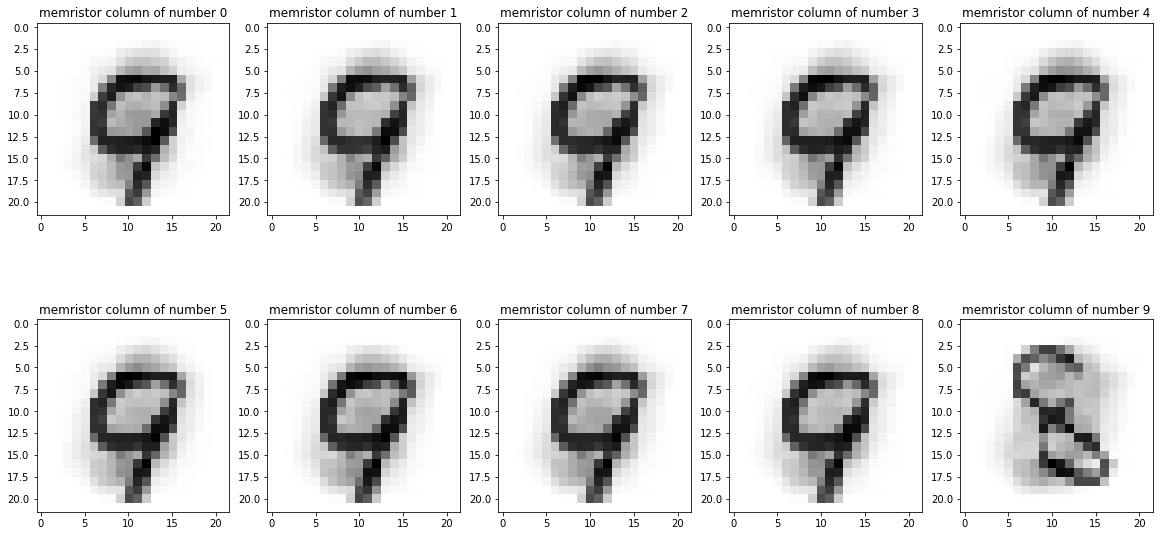

In [17]:
plt.figure(figsize=(20,10))
for i in range(1,11):
    exec("ax_%d = plt.subplot(2,5,%d)"%(i,i))

for i in range(10):
    mem_list = np.transpose(train_2.mem_matrix['r'])[i]
    a = np.reshape(mem_list, [train_2.size,train_2.size])
    exec("ax_%d.imshow(a, cmap='gray')"%(i+1))
    exec("ax_%d.set_title('memristor column of number %d')"%(i+1,i))

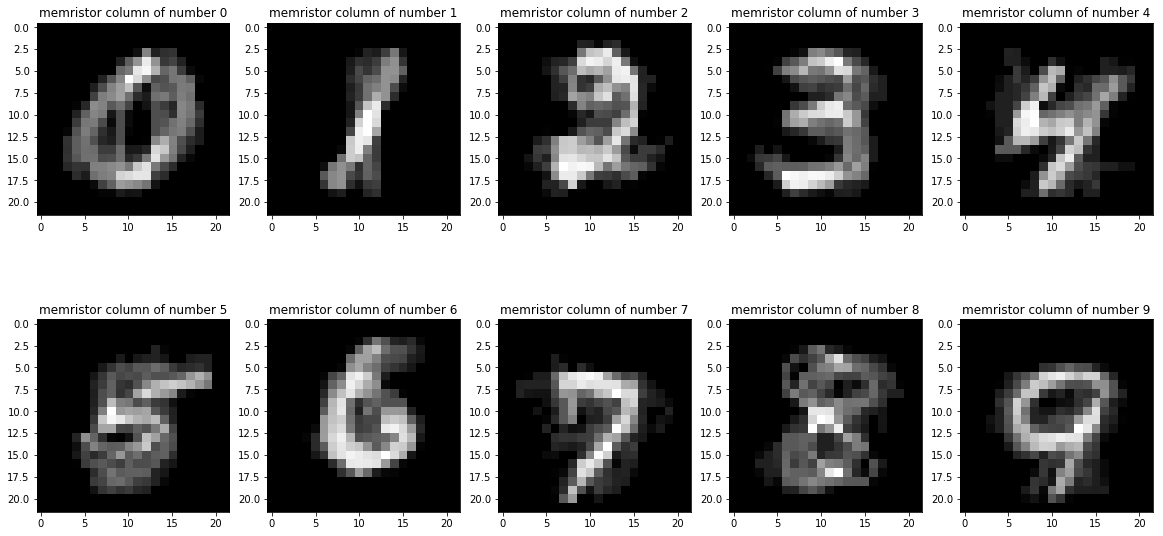

In [18]:
plt.figure(figsize=(20,10))
for i in range(1,11):
    exec("ax_%d = plt.subplot(2,5,%d)"%(i,i))

for i in range(10):
    mem_list = np.transpose(train_2.mem_matrix['o'])[i]
    a = np.reshape(mem_list, [train_2.size,train_2.size])
    exec("ax_%d.imshow(a, cmap='gray')"%(i+1))
    exec("ax_%d.set_title('memristor column of number %d')"%(i+1,i))

### white space experiment

In [ ]:
white_space = np.zeros([1,28*28])
white_space += 1.0

In [ ]:
pil_im_1 = Image.fromarray(np.reshape(white_space, [28,28]))
input_array_1 = np.reshape(np.array(pil_im_1.resize([22, 22])), [1, 22**2])[0]
plt.plot(train_2.total_output(input_array_1))
plt.show()

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(train_2.accuracy_list)
plt.xlim([0,100])
plt.grid()
plt.ylim([0,100])
plt.ylabel('Accuracy(%)')
plt.xlabel('Number of Times')

In [ ]:
plt.figure(figsize=(20,10))
plt.xlim([0,100])
plt.grid()
plt.ylim([0,25])
plt.ylabel('Loss')
plt.xlabel('Number of Times')
plt.plot(train_2.loss_list)